<a href="https://colab.research.google.com/github/intelligenxe/gym-anytrading-RL/blob/main/RL_Trading_Agent_4_0(inx).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install git+https://github.com/DLR-RM/stable-baselines3@feat/gymnasium-support
!pip install git+https://github.com/Stable-Baselines-Team/stable-baselines3-contrib@feat/gymnasium-support

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/DLR-RM/stable-baselines3 (to revision feat/gymnasium-support) to /tmp/pip-req-build-5_cabacx
  Running command git clone --filter=blob:none --quiet https://github.com/DLR-RM/stable-baselines3 /tmp/pip-req-build-5_cabacx
  Running command git checkout -q feat/gymnasium-support
  error: pathspec 'feat/gymnasium-support' did not match any file(s) known to git
  error: subprocess-exited-with-error
  
  × git checkout -q feat/gymnasium-support did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error: subprocess-exited-with-error

× git checkout -q feat/gymnasium-support did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.
Looking in indexes: https://pypi.org/

In [ ]:
!pip install gym-anytrading

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install shimmy>=0.2.1

In [ ]:
!pip install finta

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install quantstats

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Gym stuff
import gym
import gym_anytrading
from gym_anytrading.envs import StocksEnv

# Stable baselines - rl stuff
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import A2C
from stable_baselines3.common.sb2_compat.rmsprop_tf_like import RMSpropTFLike

#Quant Finance
from finta import TA
import quantstats as qs

# Processing libraries
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

/usr/local/lib/python3.10/dist-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(


# Stock Market Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

with open('/content/drive/MyDrive/Alpaca_Keys.txt', 'r') as f:
  keys = f.readlines()

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# from a list of keys we take the first one - '/n'
api_key = keys[0][:-1]
secret_key = keys[1]

## Alpaca

In [ ]:
!pip install alpaca-py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from alpaca.data.historical import StockHistoricalDataClient
from alpaca.data.requests import StockBarsRequest
from alpaca.data.timeframe import TimeFrame
from datetime import datetime


client = StockHistoricalDataClient(api_key,secret_key)

request_params = StockBarsRequest(
                        symbol_or_symbols=["AAPL"],
                        timeframe=TimeFrame.Minute,
                        start=datetime(2022, 5, 1)
                 )

bars = client.get_stock_bars(request_params)

In [ ]:
data = bars.df
data = data.droplevel(0)
data.head()

,open,high,low,close,volume,trade_count,vwap
timestamp,,,,,,,
2022-05-02 06:03:00+00:00,158.87,158.87,158.87,158.87,155.0,1.0,158.870000
2022-05-02 08:00:00+00:00,158.60,158.60,158.10,158.10,1628.0,63.0,158.501824
2022-05-02 08:01:00+00:00,158.54,158.54,158.48,158.48,1050.0,76.0,158.460895
2022-05-02 08:02:00+00:00,158.54,158.54,158.54,158.54,240.0,21.0,158.587792
2022-05-02 08:03:00+00:00,158.63,158.64,158.53,158.53,2246.0,75.0,158.575588


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 208570 entries, 2022-05-02 06:03:00+00:00 to 2023-05-12 18:11:00+00:00
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   open         208570 non-null  float64
 1   high         208570 non-null  float64
 2   low          208570 non-null  float64
 3   close        208570 non-null  float64
 4   volume       208570 non-null  float64
 5   trade_count  208570 non-null  float64
 6   vwap         208570 non-null  float64
dtypes: float64(7)
memory usage: 12.7 MB


In [ ]:
data = data.rename(columns = {'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close', 'volume': 'Volume'})

## Alpha Vantage

In [ ]:
#Download 3 months of data (Alphavantage only provides 1 month per call)
month_1 = 'https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY_EXTENDED&symbol=AAPL&interval=5min&slice=year1month1&apikey={key}&datatype=csv'
month_2 = 'https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY_EXTENDED&symbol=AAPL&interval=5min&slice=year1month2&apikey={key}&datatype=csv'
month_3 = 'https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY_EXTENDED&symbol=AAPL&interval=5min&slice=year1month3&apikey={key}&datatype=csv'
month_4 = 'https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY_EXTENDED&symbol=AAPL&interval=5min&slice=year1month4&apikey={key}&datatype=csv'

#Grab the Data as CSV
csv_1 = pd.read_csv(month_1)
csv_2 = pd.read_csv(month_2)
csv_3 = pd.read_csv(month_3)
csv_4 = pd.read_csv(month_4)

#Put it into a DataFrame
data_1 = pd.DataFrame(csv_1)
data_2 = pd.DataFrame(csv_2)
data_3 = pd.DataFrame(csv_3)
data_4 = pd.DataFrame(csv_4)


#Append the three months into one Dataframe
data = data_1.append([data_2, data_3, data_4])

data.head(3)

In [ ]:
data.info()

In [ ]:
data = data.rename(columns = {'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close', 'volume': 'Volume'})

data['time'] = pd.to_datetime(data['time'])
data.set_index('time', inplace=True)
data.sort_values('time', ascending=True, inplace=True)

data.head()

## Add Custom Indicators

In [ ]:
data['return'] = np.log(data['Close'] / data['Close'].shift(1))

In [ ]:
#Create columns for technical indicators & add them to the dataframe
data['RSI'] = TA.RSI(data,16)
data['SMA'] = TA.SMA(data, 20)
data['SMA_L'] = TA.SMA(data, 41)
data['OBV'] = TA.OBV(data)
#data['VWAP'] = TA.VWAP(data)
data['EMA'] = TA.EMA(data)
data['ATR'] = TA.ATR(data)
data.fillna(0, inplace=True)

In [ ]:
#Add momentum, volatitlity, & distance to the data_frame
data['momentum'] = data['return'].rolling(5).mean().shift(1)
data['volatility'] = data['return'].rolling(20).std().shift(1)
data['distance'] = (data['Close'] - data['Close'].rolling(50).mean()).shift(1)

In [ ]:
#Perform a simple linear regression direction prediction
lags = 5

cols = []
for lag in range(1, lags + 1):
  col = f'lag_{lag}'
  data[col] = data['Close'].shift(lag)
  cols.append(col)

data.dropna(inplace=True)

reg = np.linalg.lstsq(data[cols], data['Close'], rcond=None)[0]
data['Prediction'] = np.dot(data[cols], reg)

In [ ]:
data.tail()

,Open,High,Low,Close,Volume,trade_count,vwap,return,RSI,SMA,...,ATR,momentum,volatility,distance,lag_1,lag_2,lag_3,lag_4,lag_5,Prediction
timestamp,,,,,,,,,,,,,,,,,,,,,
2023-05-12 18:07:00+00:00,171.1100,171.27,171.0800,171.2518,78099.0,844.0,171.162938,0.000858,40.775203,171.348150,...,0.104014,-0.000064,0.000292,-0.478664,171.1050,171.2150,171.2500,171.2100,171.220,171.112899
2023-05-12 18:08:00+00:00,171.2600,171.27,171.1600,171.2250,68661.0,855.0,171.216529,-0.000157,39.521614,171.328075,...,0.106236,0.000037,0.000357,-0.326400,171.2518,171.1050,171.2150,171.2500,171.210,171.244059
2023-05-12 18:09:00+00:00,171.2150,171.25,171.2000,171.2275,41369.0,531.0,171.219199,0.000015,39.706059,171.307200,...,0.104093,0.000018,0.000356,-0.346500,171.2250,171.2518,171.1050,171.2150,171.250,171.224929
2023-05-12 18:10:00+00:00,171.2296,171.37,171.2296,171.3407,62886.0,715.0,171.302643,0.000661,47.447081,171.296235,...,0.106400,-0.000026,0.000354,-0.337150,171.2275,171.2250,171.2518,171.1050,171.215,171.228091
2023-05-12 18:11:00+00:00,171.3500,171.40,171.2850,171.3000,67999.0,744.0,171.338276,-0.000238,45.220508,171.283735,...,0.110321,0.000147,0.000383,-0.219464,171.3407,171.2275,171.2250,171.2518,171.105,171.331901


# Environment Setup

In [ ]:
#Create a function to properly format data frame to be passed through environment
def signals(env):
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]
    prices = env.df.loc[:,'Close'].to_numpy()[start:end]
    signal_features = env.df.loc[:, ['Open','High','Low','Volume','return','trade_count','momentum','volatility','distance','RSI','OBV','SMA','SMA_L','vwap','EMA','ATR', 'Prediction']].to_numpy()[start:end]
    return prices, signal_features

In [ ]:
#Replace default data process with custom function from above
class MyCustomEnv(StocksEnv):
    _process_data = signals

#Initialize an environment setting the window size and train data
window_size = 65
start_index = window_size
end_train_index = round(len(data)*0.80)
end_val_index = len(data)

env2 = MyCustomEnv(df=data, window_size=window_size, frame_bound=(start_index, end_train_index))

In [ ]:
#Create a Dummy Vector of our environment
env_maker = lambda: env2
env = DummyVecEnv([env_maker])

/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


## Train Test

In [ ]:
#initialize our model and train
policy_kwargs = dict(optimizer_class=RMSpropTFLike, optimizer_kwargs=dict(eps=1e-5))
actor_critic = A2C('MlpPolicy', env, policy_kwargs=policy_kwargs, verbose=1)
actor_critic.learn(total_timesteps=200000)

Streaming output truncated to the last 5000 lines.
|    value_loss         | 0.000363 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 381      |
|    iterations         | 4400     |
|    time_elapsed       | 57       |
|    total_timesteps    | 22000    |
| train/                |          |
|    entropy_loss       | -0.515   |
|    explained_variance | -0.0541  |
|    learning_rate      | 0.0007   |
|    n_updates          | 4399     |
|    policy_loss        | -0.07    |
|    value_loss         | 0.0315   |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 381      |
|    iterations         | 4500     |
|    time_elapsed       | 58       |
|    total_timesteps    | 22500    |
| train/                |          |
|    entropy_loss       | -0.3     |
|    explained_variance | -60.6    |
|    learning_rate      

# Testing the Model

In [ ]:
#Create a new environment with validation data
env = MyCustomEnv(df=data, window_size=window_size, frame_bound=(end_train_index, end_val_index))
obs = env.reset()

In [ ]:
while True:
    obs = obs[np.newaxis, ...]
    action, _states = actor_critic.predict(obs)
    obs, rewards, done, info = env.step(action)
    if done:
        print("info", info)
        break

info {'total_reward': 22.93620000000007, 'total_profit': 0.4671671037320184, 'position': 1}


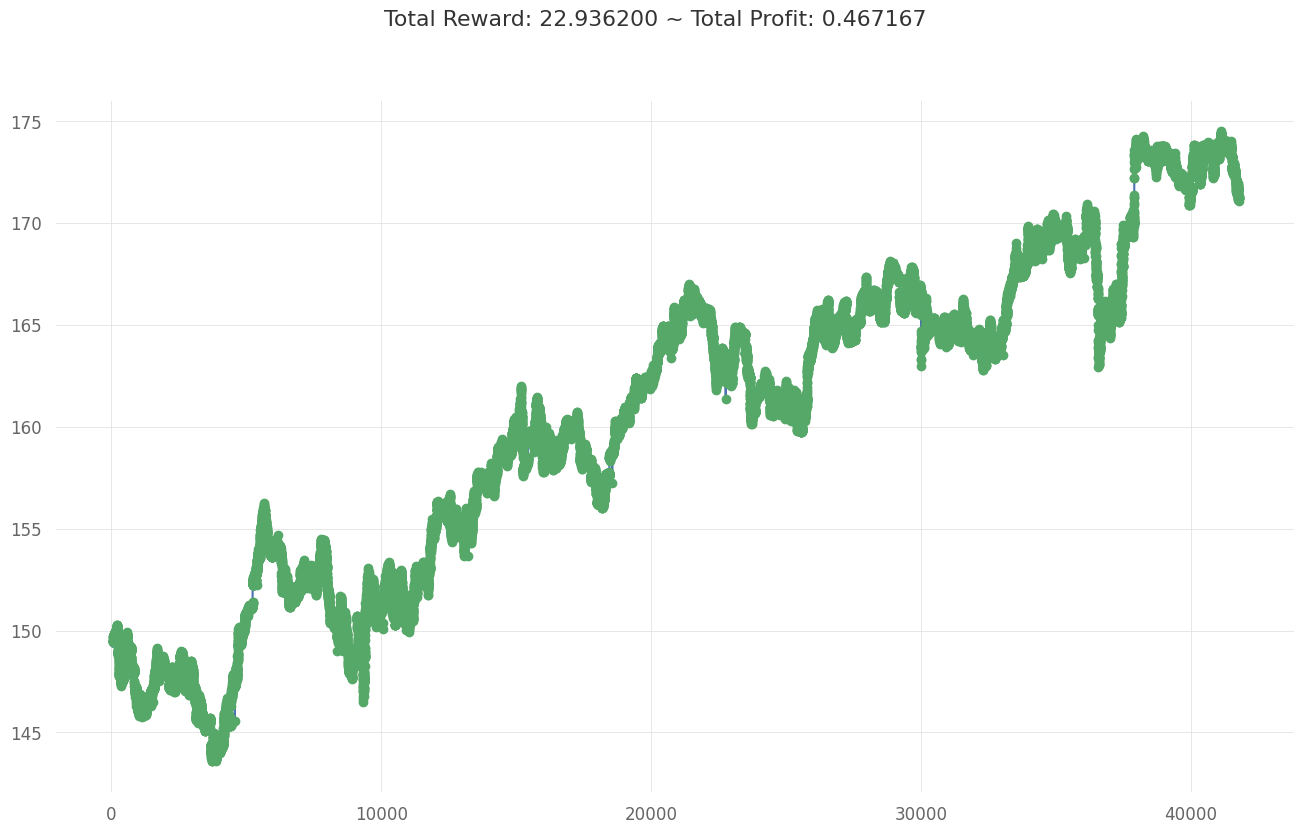

In [ ]:
#Plot the results
plt.figure(figsize=(16,9))
env.render_all()
plt.show()

In [ ]:
qs.extend_pandas()

net_worth = pd.Series(env.history['total_profit'], index=data.index[end_train_index+1:end_val_index])
returns = net_worth.pct_change().iloc[1:]

qs.reports.full(returns)

# Consider Joining the Newsletter
Get updates on new vidoes, code, and discounts on future products / services

https://witty-motivator-1414.ck.page/acb393f729